In [1]:
# !pip install text-hammer
# !pip install spacy -q
# !python -m spacy download en_core_web_sm -q
# !pip install xgboost

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
flag = False
test_df = pd.read_csv('test_data.csv')
train_df = pd.read_csv('train_data.csv')
solutions_df = pd.read_csv('train_solution.csv')

#Если код уже запускался, то не будет необходимость каждый раз заново проводить процедуру text lemmatization
try:
    clean_train_df = pd.read_csv('clean_train_df.csv')
    clean_test_df = pd.read_csv('clean_test_df.csv')
except:
    flag = True
    print('No cleaned df' )

No cleaned df


In [4]:
train_df = train_df.merge(solutions_df, right_on='id', left_on='id')

In [5]:
train_df

,id,message,category
0,271828,Over $616 million in Bitcoin was electrocated ...,1
1,271829,Quiz: Thursday or friday?,0
2,271830,The Australian Revenue Authority will start co...,1
3,271831,Let's continue😉. I present to you my new review,2
4,271832,Here comes your future palette.,2
...,...,...,...
3839,275667,"On the air, the shooter's kms and the man who ...",2
3840,275668,This shit that's off-the-books.,0
3841,275669,"Time to go to the sky, tabor.",2
3842,275670,uraaaaaaaa,0


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3844 entries, 0 to 3843
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3844 non-null   int64 
 1   message   3844 non-null   object
 2   category  3844 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 120.1+ KB


Пропущенных значений нету

In [7]:
train_df['amount_sym'] = train_df['message'].str.len()
train_df['amount_words'] = train_df['message'].str.split(' ').str.len()
train_df['amount_numbers'] = train_df['message'].str.count('\d')

Добавим три столбца:
1) Количество символов в сообщении

2) Количество слов в сообщении

3) Количество цифр в сообщении

In [8]:
train_df

,id,message,category,amount_sym,amount_words,amount_numbers
0,271828,Over $616 million in Bitcoin was electrocated ...,1,1454,242,28
1,271829,Quiz: Thursday or friday?,0,25,4,0
2,271830,The Australian Revenue Authority will start co...,1,1080,169,10
3,271831,Let's continue😉. I present to you my new review,2,48,10,0
4,271832,Here comes your future palette.,2,31,5,0
...,...,...,...,...,...,...
3839,275667,"On the air, the shooter's kms and the man who ...",2,1438,281,0
3840,275668,This shit that's off-the-books.,0,31,4,0
3841,275669,"Time to go to the sky, tabor.",2,29,7,0
3842,275670,uraaaaaaaa,0,10,1,0


In [9]:
train_df.describe()

,id,category,amount_sym,amount_words,amount_numbers
count,3844.000000,3844.000000,3844.000000,3844.000000,3844.000000
mean,273749.500000,0.945109,383.022373,66.932882,3.695890
std,1109.811546,0.827799,534.430787,92.650663,8.950198
min,271828.000000,0.000000,3.000000,1.000000,0.000000
25%,272788.750000,0.000000,33.000000,6.000000,0.000000
50%,273749.500000,1.000000,109.000000,20.000000,0.000000
75%,274710.250000,2.000000,527.500000,94.000000,4.000000
max,275671.000000,2.000000,3273.000000,606.000000,126.000000


<AxesSubplot:>

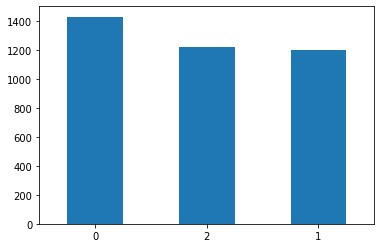

In [10]:
train_df['category'].value_counts().plot.bar(x='category', rot=0)

В целом у нас тут почти идельное распределение по типам чатов поэтому в будущем не придётся применять различные модели для балансировки.

# Text Pre-Processing

In [11]:
import text_hammer as th

Воспользуемся готовой библиотекой для чистки сообщений

In [12]:
def text_preprocessing(df, column):
    df[column] = df[column].progress_apply(lambda x:str(x).lower())
    df[column] = df[column].progress_apply(lambda x: th.cont_exp(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_emails(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_html_tags(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_stopwords(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_special_chars(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_accented_chars(x))
    df[column] = df[column].progress_apply(lambda x: th.make_base(x))
    
    return df

In [13]:
if flag == True:
    clean_train_df = text_preprocessing(train_df, "message")
    clean_test_df = text_preprocessing(test_df, "message")

  0%|          | 0/3844 [00:00<?, ?it/s]

  0%|          | 0/3844 [00:00<?, ?it/s]

  0%|          | 0/3844 [00:00<?, ?it/s]

  0%|          | 0/3844 [00:00<?, ?it/s]

  0%|          | 0/3844 [00:00<?, ?it/s]

  0%|          | 0/3844 [00:00<?, ?it/s]

  0%|          | 0/3844 [00:00<?, ?it/s]

  0%|          | 0/3844 [00:00<?, ?it/s]

  0%|          | 0/5927 [00:00<?, ?it/s]

  0%|          | 0/5927 [00:00<?, ?it/s]

  0%|          | 0/5927 [00:00<?, ?it/s]

  0%|          | 0/5927 [00:00<?, ?it/s]

  0%|          | 0/5927 [00:00<?, ?it/s]

  0%|          | 0/5927 [00:00<?, ?it/s]

  0%|          | 0/5927 [00:00<?, ?it/s]

  0%|          | 0/5927 [00:00<?, ?it/s]

In [16]:
 # нужно чтобы каждый раз не проделывать одну и туже процедуру
clean_train_df.to_csv('clean_train_df.csv')
clean_test_df.to_csv('clean_test_df.csv')

In [17]:
clean_train_df.head(5)

,id,message,category,amount_sym,amount_words,amount_numbers
0,271828,616 million bitcoin electrocate september wrap...,1,1454,242,28
1,271829,quiz thursday friday,0,25,4,0
2,271830,australian revenue authority start collect tax...,1,1080,169,10
3,271831,let continue present new review,2,48,10,0
4,271832,come future palette,2,31,5,0


In [18]:
clean_test_df.head(5)

,id,message
0,275672,lot people job fair tonight
1,275673,also get 4 answer google form
2,275674,vladimir seminar
3,275675,couple 111 too
4,275676,antibuye again zara


# Default tokenaizer + basic models

## Train Test split 

In [19]:
from sklearn.model_selection import train_test_split

In [30]:
X_train, X_test, y_train, y_test = train_test_split(clean_train_df['message'].values, 
                                                  clean_train_df['category'].values, 
                                                  test_size = 0.2, 
                                                  stratify = clean_train_df.category,
                                                  random_state = 11122022)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3075,) (769,) (3075,) (769,)


## Tokenaizer

In [31]:
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

Для начала посмотрим сколько у нас существует уникальных слов в датасете

In [32]:
def make_tokenizer(clean_train_df, X_train, X_test):
    uniq_words = {}

    for message in clean_train_df['message'].values:
        uniq_words.update(dict.fromkeys(set(message.split())))

    print("Количество уникальных значений в сообщениях: ", len(uniq_words))

    num_words = len(uniq_words)
    tokenizer = Tokenizer(num_words, lower=True)
    tokenizer.fit_on_texts(clean_train_df.message)
    print(len(tokenizer.word_index))

    # Make all sentences the same length
    max_message_lenght = clean_train_df.message.str.len().max()
    print("Максимальня длина сообщения: ", max_message_lenght)

    X_train_ = tokenizer.texts_to_sequences(X_train)
    X_train_pad = pad_sequences(X_train_, maxlen = max_message_lenght, padding='post')
    X_test_ = tokenizer.texts_to_sequences(X_test)
    X_test_pad = pad_sequences(X_test_, maxlen = max_message_lenght, padding = 'post')
    print(X_train_pad.shape, X_test_pad.shape)
    
    return X_train_pad, X_test_pad

В нашем случае вышло примерно 15000 слов(и цифр). В целом, то что тут также есть цифры не критично так как наша цель найти максимальное значение для того, что позже воспользоваться им при использование Tokenizer. И будет не критично если у нас будет больше значений так как все лишние буду занулены.
В целом конечно можно посмотреть как часто встречается каждое слово в частности, но в нашем случае это излишне так как никак не может повлиять на конечную точность модели с учётом всех вводных задания

In [33]:
%%time
X_train_pad, X_test_pad = make_tokenizer(clean_train_df,X_train,X_test)

Количество уникальных значений в сообщениях:  14907
14902
Максимальня длина сообщения:  1909
(3075, 1909) (769, 1909)
Wall time: 546 ms


## Model

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
import xgboost as xgb

###  LogisticRegression

In [35]:
def logreg(X_train_pad, y_train, y_test):
    model_logreg = LogisticRegression()
    model_logreg.fit(X_train_pad, y_train)
    y_pred_logreg = model_logreg.predict(X_test_pad)
    acc = np.round(accuracy_score(y_pred_logreg, y_test), 4)
    print('accuracy: ', acc)
    print(classification_report(y_test, y_pred_logreg))
    
    return y_pred_logreg, acc

In [36]:
%%time
y_pred_logreg, acc_logreg = logreg(X_train_pad, y_train, y_test)

accuracy:  0.5904
              precision    recall  f1-score   support

           0       0.66      0.87      0.75       286
           1       0.62      0.45      0.52       240
           2       0.44      0.40      0.42       243

    accuracy                           0.59       769
   macro avg       0.58      0.57      0.56       769
weighted avg       0.58      0.59      0.57       769

Wall time: 1.7 s


c:\users\egorm\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### XGBOOST 

In [37]:
def xgboost(X_train_pad, y_train, y_test):
    model_xgb = xgb.XGBClassifier(objective='multi:softmax', 
                          num_class=3,
                          max_depth=6, 
                          learning_rate=0.1, 
                          n_estimators=100, 
                          subsample=0.8)

    model_xgb.fit(X_train_pad, y_train)
    y_pred_xgb = model_xgb.predict(X_test_pad)
    acc = np.round(accuracy_score(y_test, y_pred_xgb), 4)
    print ('accuracy: ', acc)
    print(classification_report(y_test, y_pred_xgb))
    
    return y_pred_xgb, acc

In [38]:
%%time
y_pred_xgboost, acc_xgboost = xgboost(X_train_pad, y_train, y_test)

accuracy:  0.6918
              precision    recall  f1-score   support

           0       0.72      0.85      0.78       286
           1       0.73      0.73      0.73       240
           2       0.59      0.47      0.52       243

    accuracy                           0.69       769
   macro avg       0.68      0.68      0.68       769
weighted avg       0.68      0.69      0.68       769

Wall time: 25.2 s


Как можно заметить результаты(без особых "настроек" модели) вышли очень низкими: ~0.59 и ~0.69

# TF-IDF + RandomForestClassifier

In [40]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

## Train Test split 

In [41]:
X_train, X_test, y_train, y_test = train_test_split(clean_train_df['message'].values.astype('U'), 
                                                  clean_train_df['category'].values.astype('U'), 
                                                  test_size = 0.2, 
                                                  stratify = clean_train_df.category,
                                                  random_state = 11122022)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3075,) (769,) (3075,) (769,)


## TFIDF 

In [42]:
tfidf_vectorizer = TfidfVectorizer() 
tfidf_train_vectors = tfidf_vectorizer.fit_transform(X_train)
tfidf_test_vectors = tfidf_vectorizer.transform(X_test)
tfidf_target_vectors = tfidf_vectorizer.transform(clean_test_df.message)

## RandomForestClassifier

In [50]:
classifier = RandomForestClassifier()

classifier.fit(tfidf_train_vectors, y_train)

y_pred = classifier.predict(tfidf_test_vectors)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.75      0.92      0.83       286
           1       0.98      0.90      0.94       240
           2       0.88      0.72      0.79       243

    accuracy                           0.85       769
   macro avg       0.87      0.85      0.85       769
weighted avg       0.86      0.85      0.85       769



Самая дефолтная верся показала результат в 0.85, что довольно неплохо

In [92]:
y_pred_rfc_final = classifier.predict(tfidf_target_vectors)
solutions = pd.DataFrame(y_pred_rfc_final)
solutions = solutions.reset_index()
solutions.set_axis(['id', 'category'], axis=1, inplace=True)
solutions['category'] = solutions['category'].astype('int64')
solutions.to_csv('solutions.csv', sep =',')